<a href="https://colab.research.google.com/github/Muskanateeq/Spam-Email-Classification/blob/main/final_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-classification-dataset/combined_data.csv


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Bidirectional
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [ ]:
df=pd.read_csv("/kaggle/input/email-spam-classification-dataset/combined_data.csv")
df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In this dataset:

1. '1' indicates that the email is spam.
2. '0' indicates that the email is real.

In [ ]:
print(df.isnull().sum())

label    0
text     0
dtype: int64


In [ ]:
df.shape

(83448, 2)

In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].apply(remove_special_characters)

In [ ]:
#Stop-words in English
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

#Tokenize the text
df['text'] = df['text'].apply(word_tokenize)

#Remove stop words
df['text'] = df['text'].apply(remove_stop_words)

#Rejoin words for EDA
df['text'] = df['text'].apply(' '.join)

In [ ]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

In [ ]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['label'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested http dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations con

In [ ]:
for i in range (1,3):
    print("Email #"+str(i))
    legitimate_email = df[df['label'] == 0]['text'].iloc[i]
    print(legitimate_email+"\n")

Email #1
thanks answers guys know checked rsync manual would rather get escapenumber sure answer one current script bin bash rsync avt exclude alpha exclude arm exclude hppa exclude hurd exclude iaescapenumber exclude mescapenumberk exclude mips exclude mipsel exclude multi arch exclude powerpc exclude sescapenumber exclude sh exclude sparc exclude source ftp de debian org debian cd var www mirror debian cd know loads excludes include distros soon rsync manual del alias delete delete delete extraneous files dest dirs delete receiver deletes transfer default delete receiver deletes xfer delete receiver deletes transfer delete excluded also delete excluded files dest dirs delete would suggest use thanks john escapelong escapenumber escapenumber escapenumber olleg samoylov wrote jonathan escapelong wrote sorry banal question favourite keys escapenumber stage rsync rsync verbose recursive links hard links times filter r tmp delete delay updates source url destination log file olleg samoylo

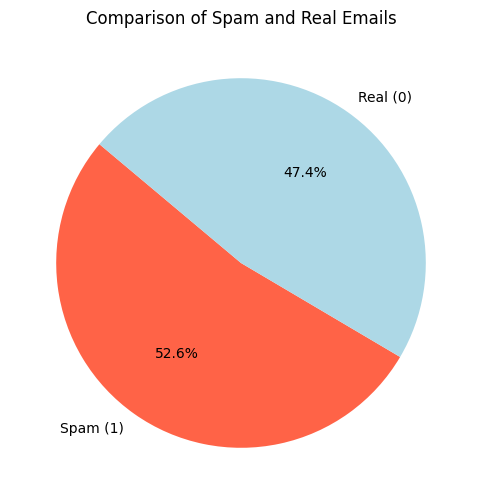

In [ ]:
#Number of spam and Real emails
email_counts = df['label'].value_counts()

#Plotting
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Real (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Real Emails')
plt.show()

In [ ]:
#Spam and Real emails
spam_emails = df[df['label'] == 1]['text']
legit_emails = df[df['label'] == 0]['text']

spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for real emails
legit_words = Counter()
legit_emails.apply(lambda x: legit_words.update(x.split()))

#Most common words in spam and real emails
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

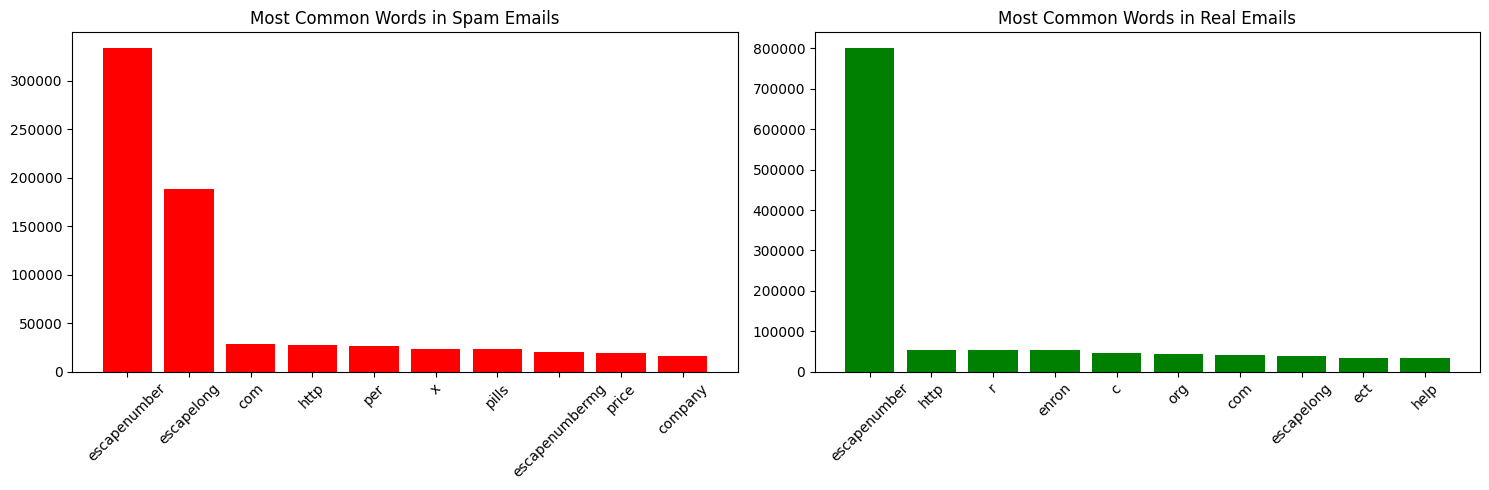

In [ ]:
#Most common words in spam emails
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails')
plt.xticks(rotation=45)

#Most common words in real emails
plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('Most Common Words in Real Emails')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

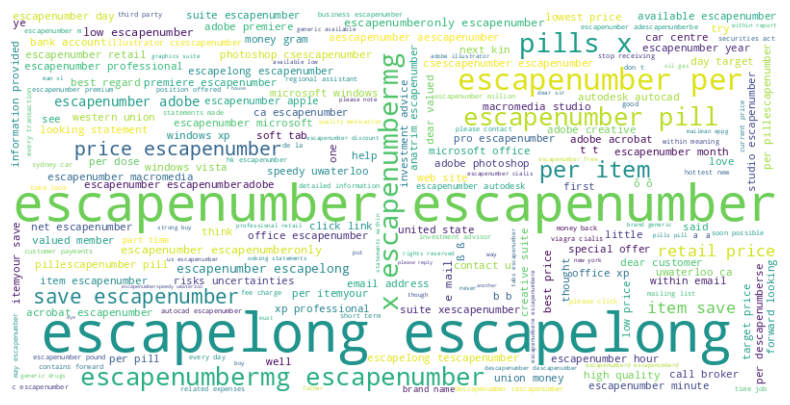

In [ ]:
#Image of spam words
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails))

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

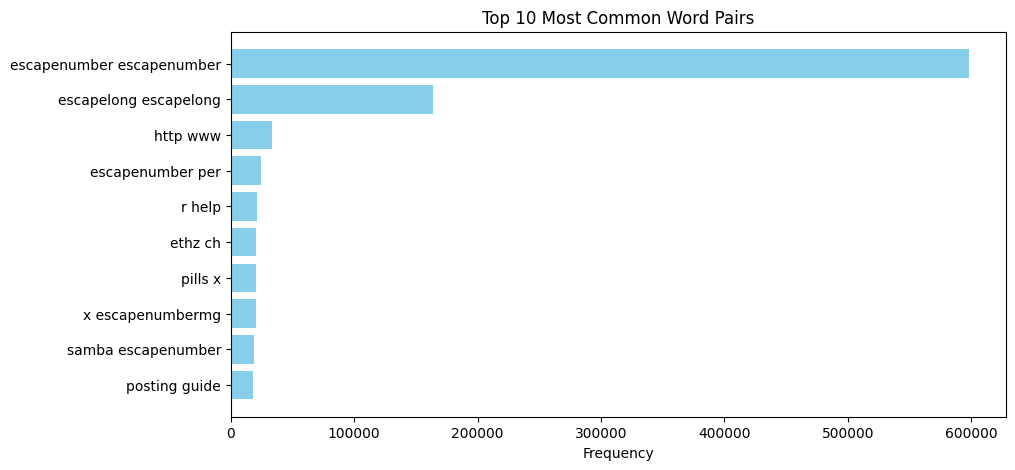

In [ ]:
def generate_ngrams(text, n=2):
    #text into words
    words = text.split()
    #there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

#Common Word Pairs
df['Word Pairs'] = df['text'].apply(lambda x: generate_ngrams(x, n=2))

#frequencies
bigram_counts = Counter([bigram for sublist in df['Word Pairs'] for bigram in sublist])


most_common_bigrams = bigram_counts.most_common(10)

#DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Word Pairs', 'Frequency'])

#most common Word pair
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Word Pairs'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Word Pairs')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#data splitting
X = df['text']
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
#Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1305.4409692263446


In [ ]:
max_length = 500

# sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=512,
                    epochs=3,
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/3
115/115 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9659 - loss: 0.1126 - val_accuracy: 0.9742 - val_loss: 0.0923
Epoch 2/3
115/115 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9802 - loss: 0.0674 - val_accuracy: 0.9813 - val_loss: 0.0631
Epoch 3/3
115/115 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9887 - loss: 0.0402 - val_accuracy: 0.9764 - val_loss: 0.0786


In [ ]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

783/783 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step


In [ ]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

Precision: 96.34%
Recall: 99.29%
F1 Score: 97.79%


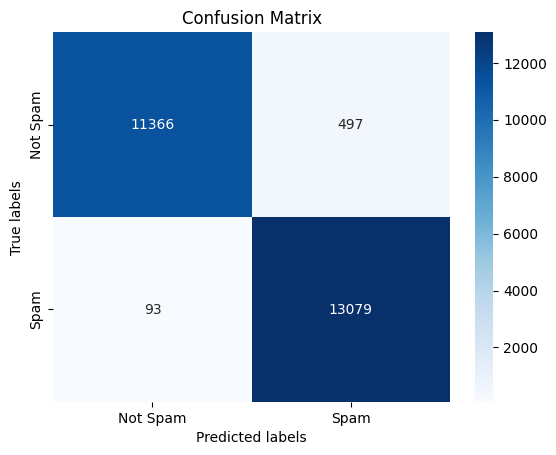

In [ ]:
#Confusion Matrix
ax= plt.subplot()

sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [ ]:
email_1 = ["Congratulations! You have won a free iPhone. Click the link to claim now."]
sequence_1 = tokenizer.texts_to_sequences(email_1)
padded_1 = pad_sequences(sequence_1, maxlen=max_length, padding='post')
prediction_1 = model.predict(padded_1)
label_1 = "Spam" if prediction_1[0] > 0.5 else "Real"
print(f"Email: {email_1[0]}\nPrediction: {label_1}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Email: Congratulations! You have won a free iPhone. Click the link to claim now.
Prediction: Spam



In [ ]:
email_2 = ["Dear customer, your bank account needs verification. Please tell me Received OTP for verification."]
sequence_2 = tokenizer.texts_to_sequences(email_2)
padded_2 = pad_sequences(sequence_2, maxlen=max_length, padding='post')
prediction_2 = model.predict(padded_2)
label_2 = "Spam" if prediction_2[0] > 0.5 else "Real"
print(f"Email: {email_2[0]}\nPrediction: {label_2}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Email: Dear customer, your bank account needs verification. Please update your details immediately.
Prediction: Spam



In [ ]:
email_3 = ["Hey, let's catch up for coffee this weekend. Let me know your availability."]
sequence_3 = tokenizer.texts_to_sequences(email_3)
padded_3 = pad_sequences(sequence_3, maxlen=max_length, padding='post')
prediction_3 = model.predict(padded_3)
label_3 = "Spam" if prediction_3[0] > 0.5 else "Real"
print(f"Email: {email_3[0]}\nPrediction: {label_3}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Email: Hey, let's catch up for coffee this weekend. Let me know your availability.
Prediction: Real



In [ ]:
email_4 = ["Hi John, just confirming our meeting tomorrow at 10 AM. Let me know if you need to reschedule."]
sequence_1 = tokenizer.texts_to_sequences(email_1)
padded_1 = pad_sequences(sequence_1, maxlen=max_length, padding='post')
prediction_1 = model.predict(padded_1)
label_1 = "Spam" if prediction_1[0] > 0.5 else "Real"
print(f"Email: {email_1[0]}\nPrediction: {label_1}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Email: Hi John, just confirming our meeting tomorrow at 10 AM. Let me know if you need to reschedule.
Prediction: Real



In [ ]:
email_5 = ["Dear Candidate, we are pleased to invite you for an interview for the Software Engineer position at ABC Corp. Please reply with your availability."]
sequence_3 = tokenizer.texts_to_sequences(email_3)
padded_3 = pad_sequences(sequence_3, maxlen=max_length, padding='post')
prediction_3 = model.predict(padded_3)
label_3 = "Spam" if prediction_3[0] > 0.5 else "Real"
print(f"Email: {email_3[0]}\nPrediction: {label_3}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Email: Hey, let's catch up for coffee this weekend. Let me know your availability.
Prediction: Real

